# Work in Progress

`Attribute Information:`

1. date : Date in MM-DD-YYYY
2. day : Day of the Week
3. quarter : A portion of the month. A month was divided into four quarters
4. department : Associated department with the instance
5. team : Associated team number with the instance
6. no_of_workers : Number of workers in each team
7. no_of_style_change : Number of changes in the style of a particular product
8. targeted_productivity : Targeted productivity set by the Authority for each team for each day.
9. smv : Standard Minute Value, it is the allocated time for a task
10. wip : Work in progress. Includes the number of unfinished items for products
11. overtime : Represents the amount of overtime by each team in minutes
12. incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
13. idletime : The amount of time when the production was interrupted due to several reasons
14. idlemen : The number of workers who were idle due to production interruption
15. actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.

# Load Libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

In [3]:
data = pd.read_csv('garments_worker_productivity.csv')
print(data.shape)
data.head()

(1197, 15)


date   quarter  department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1      sweing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing   Thursday     1                   0.75   
2  1/1/2015  Quarter1      sweing  Thursday    11                   0.80   
3  1/1/2015  Quarter1      sweing  Thursday    12                   0.80   
4  1/1/2015  Quarter1      sweing  Thursday     6                   0.80   

     smv     wip  over_time  incentive  idle_time  idle_men  \
0  26.16  1108.0       7080         98        0.0         0   
1   3.94     NaN        960          0        0.0         0   
2  11.41   968.0       3660         50        0.0         0   
3  11.41   968.0       3660         50        0.0         0   
4  25.90  1170.0       1920         50        0.0         0   

   no_of_style_change  no_of_workers  actual_productivity  
0                   0           59.0             0.940725  
1                   0            8.0             0.886500  
2                   0           30.5             0.800570  
3                   0           30.5             0.800570  
4                   0           56.0             0.800382

# EDA
Inspect, Clean, and Validate a Dataset.
Show underlying patterns and relationships within datasets.

1. Convert date to datetime dtypes
1. Quater column to categorical dtypes
2. Rename Department column wrong typo's and set to categorical dtype (nominal) 
3. Day column to categorical dtypes
4. Impute WIP column NaN values using NOCB/LOCF method
5. Inspect highly missing data (60% and up)(Large frequency of zeros can't give us useful information)
6. Checking for duplicate entries

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

#### 1. Convert date to datetime dtype

In [5]:
# date format is MM-DD-YYYY
data['date'] = pd.to_datetime(data.date, format="%m/%d/%Y")

#### 2. Quater column to categorical dtypes

In [6]:
data.quarter.value_counts()

Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: quarter, dtype: int64

In [7]:
quarter_order = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5' ]
data.quarter = pd.Categorical(data.quarter, quarter_order, ordered=True)
# verify quarter order
data.quarter.unique()

['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4', 'Quarter5']
Categories (5, object): ['Quarter1' < 'Quarter2' < 'Quarter3' < 'Quarter4' < 'Quarter5']

#### 3. Rename department column wrong typo's and convert to categorical dtypes

In [8]:
data.department.value_counts()

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

In [9]:
data['department'] = data['department'].replace(['sweing'], 'sewing')
data['department'] = data['department'].replace(['finishing '], 'finishing')
data['department'] = data.department.astype('category')

data.department.value_counts()

sewing       691
finishing    506
Name: department, dtype: int64

#### 4. Day column to categorical dtypes

In [10]:
data.day.unique()

array(['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [11]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday', 'Sunday' ]
data.day = pd.Categorical(data.day, day_order, ordered=True)
# verify day order
data.day.unique()

['Thursday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
Categories (6, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Saturday' < 'Sunday']

#### 5. Impute WIP with NaN values using NOCB/LOCF method
NOCB usually used when we have more recent data, and we know enough about the past to fill in the blanks. 

Though this may need further investigation. Ask how the data is structured/collected. 

In [12]:
data.wip.bfill(axis=0, inplace=True)
# verify
data.tail(6)

date   quarter department        day  team  targeted_productivity  \
1191 2015-03-11  Quarter2     sewing  Wednesday     7                   0.65   
1192 2015-03-11  Quarter2  finishing  Wednesday    10                   0.75   
1193 2015-03-11  Quarter2  finishing  Wednesday     8                   0.70   
1194 2015-03-11  Quarter2  finishing  Wednesday     7                   0.65   
1195 2015-03-11  Quarter2  finishing  Wednesday     9                   0.75   
1196 2015-03-11  Quarter2  finishing  Wednesday     6                   0.70   

        smv    wip  over_time  incentive  idle_time  idle_men  \
1191  30.48  935.0       6840         26        0.0         0   
1192   2.90    NaN        960          0        0.0         0   
1193   3.90    NaN        960          0        0.0         0   
1194   3.90    NaN        960          0        0.0         0   
1195   2.90    NaN       1800          0        0.0         0   
1196   2.90    NaN        720          0        0.0         0   

      no_of_style_change  no_of_workers  actual_productivity  
1191                   1           57.0             0.650596  
1192                   0            8.0             0.628333  
1193                   0            8.0             0.625625  
1194                   0            8.0             0.625625  
1195                   0           15.0             0.505889  
1196                   0            6.0             0.394722

There is still Nan values. Let's use the LOCF (stands for Last Observation Carried Forward)

In [14]:
data.wip.ffill(axis=0, inplace=True)
# verify
print(data['wip'].isna().sum())
data.tail(2)

0


date   quarter department        day  team  targeted_productivity  \
1195 2015-03-11  Quarter2  finishing  Wednesday     9                   0.75   
1196 2015-03-11  Quarter2  finishing  Wednesday     6                   0.70   

      smv    wip  over_time  incentive  idle_time  idle_men  \
1195  2.9  935.0       1800          0        0.0         0   
1196  2.9  935.0        720          0        0.0         0   

      no_of_style_change  no_of_workers  actual_productivity  
1195                   0           15.0             0.505889  
1196                   0            6.0             0.394722

#### 6. Inspect highly missing data (60% and up) / zero value

We will drop this columns prior to fitting in a Machine Learning model, for now let's investigate this missing/zero value data.

In [15]:
# how many zeros are there in each columns?
(data == 0).sum(axis=0) 

date                        0
quarter                     0
department                  0
day                         0
team                        0
targeted_productivity       0
smv                         0
wip                         0
over_time                  31
incentive                 604
idle_time                1179
idle_men                 1179
no_of_style_change       1050
no_of_workers               0
actual_productivity         0
dtype: int64

In [16]:
# proportion zeros in each columns?
(data == 0).sum(axis=0)  / len(data) * 100

date                      0.000000
quarter                   0.000000
department                0.000000
day                       0.000000
team                      0.000000
targeted_productivity     0.000000
smv                       0.000000
wip                       0.000000
over_time                 2.589808
incentive                50.459482
idle_time                98.496241
idle_men                 98.496241
no_of_style_change       87.719298
no_of_workers             0.000000
actual_productivity       0.000000
dtype: float64

We have a very large proportion of `idle_time`, `idle_men` and `number_of_style_change`. This is also a good indication that the the production is running smoothly. With large zero's proportion it's safe to drop this columns prior fitting to Machine Learning Model. 

Let's investigate first these `idles`, when it occurs? how much time this idle waste? with this information we can easily ask questions about the incidents. Also this information will help us mitigate the occurence of the incident and can further improve the production. 

1. What teams are belong in sewing department?
2. What teams are belong in finishing department?

In [138]:
Contingency_table = pd.crosstab(data.department, data.team)
Contingency_table

team        1   2   3   4   5   6   7   8   9   10  11  12
department                                                
finishing   49  52  37  46  35  35  41  53  46  43  29  40
sewing      56  57  58  59  58  59  55  56  58  57  59  59

In [15]:
# droping columns
# data = data.drop(columns=['idle_time', 'idle_men', 'no_of_style_change'])
# data.head(2)

date   quarter department       day  team  targeted_productivity  \
0  1/1/2015  Quarter1     sewing  Thursday     8                   0.80   
1  1/1/2015  Quarter1  finishing  Thursday     1                   0.75   

     smv     wip  over_time  incentive  no_of_workers  actual_productivity  
0  26.16  1108.0       7080         98           59.0             0.940725  
1   3.94   968.0        960          0            8.0             0.886500

#### 6. Duplicates

In [72]:
# variable that store duplicates exactly the same as another row
dups = data.duplicated()
# count duplicates
dups.value_counts()

False    1197
dtype: int64

Our dataset has no duplicates.

#### 7. Visualization

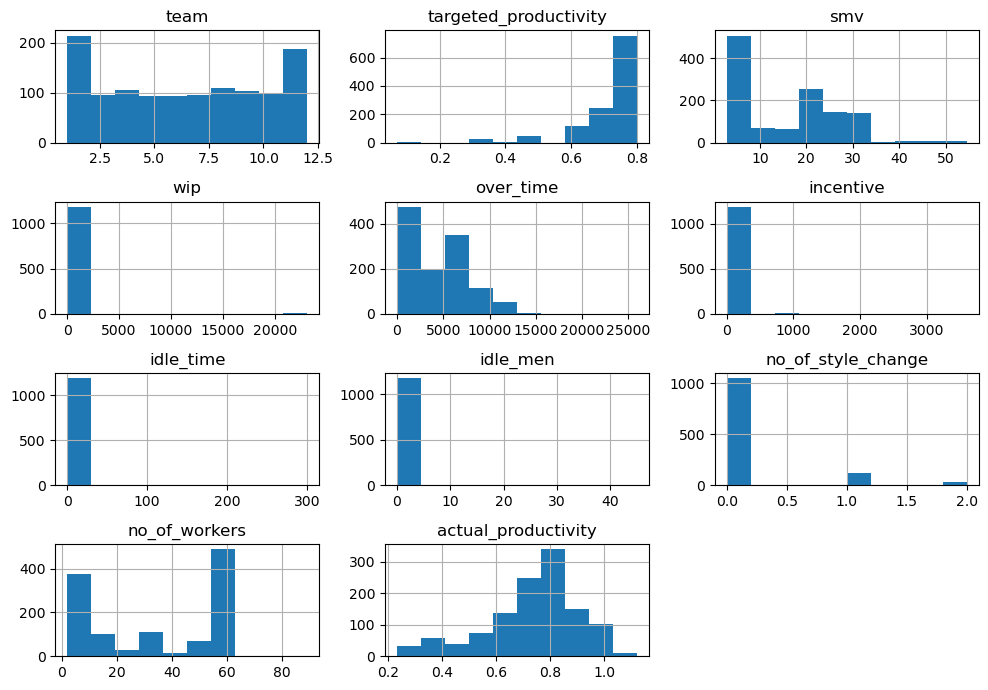

In [77]:
# we will not include data in this visualization
data.drop(columns=['date']).hist(figsize=(10, 7))
plt.tight_layout()
plt.show()

#### Check for skewness
Skewness is a measure of asymmetry of a distribution.
`Important Notes:`
-  between -0.5 and 0.5, the data are fairly symmetrical
-  between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
-  less than -1 or greater than 1, the data are highly skewed

In [79]:
# selected columns only
data_int = ['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'no_of_workers', 'actual_productivity']
for i in data_int:
    print(i + ' ==> ' + str(round(data[i].skew(),2)))

team ==> 0.01
targeted_productivity ==> -2.14
smv ==> 0.41
wip ==> 10.06
over_time ==> 0.67
incentive ==> 15.79
no_of_workers ==> -0.11
actual_productivity ==> -0.81


#### Kurtosis() 
kurtosis determines the heaviness of the distribution tails. Determine the volume of the outlier.
- If the distribution is tall and thin it is called a `leptokurtic` distribution(Kurtosis > 3). Values in a leptokurtic distribution are near the mean or at the extremes.
- A flat distribution where the values are moderately spread out is called `platykurtic`(Kurtosis <3) distribution.
- A distribution whose shape is in between a leptokurtic distribution and a platykurtic distribution is called a `mesokurtic`(Kurtosis=3) distribution. A mesokurtic distribution looks more close to a normal distribution.

'Note' 
1. High kurtosis in a data set is an indicator that data has heavy outliers.
2. Low kurtosis in a data set is an indicator that data has lack of outliers.
3. If kurtosis value + means pointy and — means flat.

In [80]:
data.kurt()

C:\Users\Toto\AppData\Local\Temp\ipykernel_25672\2907027414.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.kurt()


team                      -1.223906
targeted_productivity      5.613701
smv                       -0.795346
wip                      110.607807
over_time                  0.424364
incentive                299.032462
idle_time                442.638160
idle_men                 102.962869
no_of_style_change         8.181490
no_of_workers             -1.788108
actual_productivity        0.333227
dtype: float64

1. `team`s Activity seems fairly distributed and flat
2. `target productivity` Heavily left skewed which is a great. Target productivy should be in increasing value.
3. `smv` Distribution is faily symmetrical
4. `wip` Heavily right skewed, as seen in above graph <font color='red'>outliers are affecting the distribution!</font>. Kurtosis at 110 indicating that the distribution is very tall. Also distribution has heavy outliers.
5. `over_time` Moderately skewed
6. `incentive` Heavily right skewed. <font color='red'>There must some extremely high incentives!</font>. Kurtosis at 299 we should do an investigation with the outliers.
7. `no_of_worker` Looks like a bimodal distribution, <font color='red'>we can form a clusters/groups for this kind of  distribution.</font>
8. `Actual_productiviy` Moderately left skewed. This is a good sign.


#### Final checking

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   category      
 2   department             1197 non-null   category      
 3   day                    1197 non-null   category      
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    1197 non-null   float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   int64         
 12  no_of_style_change     1197 non-null   int64         
 13  no_

# Statistical Analysis

### Descriptive

#### Univiriate Analysis

`1.` What is the average overtime? average is more reliable than mean if the distribution is more symetric.

In [82]:
round(np.mean(data.over_time))

4567

`2.` Highest and lowest incentive? (except zero for lowest)

In [83]:
# highest incentive
np.max(data.incentive)

3600

In [84]:
# lowest incentive except zero
data.incentive[data.incentive !=0].min()

21

`3.` Average actual productivty?

In [85]:
np.mean(data.actual_productivity)

0.7350910969791159

#### Biviriate

`1.` Actual vs. target productivity

In [102]:
# add another column for months
data['month'] = data['date'].dt.month
data.month.unique()

array([1, 2, 3], dtype=int64)

In [117]:
plt.plot(data.date, data.actual_productivity, marker='o')
plt.xlim(20150101, 20150115)

(20150101, 20150115)

ValueError: Date ordinal 20150101.0 converts to 57139-02-08T00:00:00.000000 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

<Figure size 640x480 with 1 Axes>

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   category      
 2   department             1197 non-null   category      
 3   day                    1197 non-null   category      
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    1197 non-null   float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  no_of_workers          1197 non-null   float64       
 11  actual_productivity    1197 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(5), int64(3)
memory

In [42]:
data.iloc[1000:-1]

date   quarter department        day  team  targeted_productivity  \
1000 2015-03-01  Quarter1  finishing     Sunday     2                   0.70   
1001 2015-03-01  Quarter1     sewing     Sunday     7                   0.80   
1002 2015-03-01  Quarter1  finishing     Sunday     1                   0.60   
1003 2015-03-01  Quarter1  finishing     Sunday     9                   0.75   
1004 2015-03-01  Quarter1  finishing     Sunday     7                   0.80   
...         ...       ...        ...        ...   ...                    ...   
1191 2015-03-11  Quarter2     sewing  Wednesday     7                   0.65   
1192 2015-03-11  Quarter2  finishing  Wednesday    10                   0.75   
1193 2015-03-11  Quarter2  finishing  Wednesday     8                   0.70   
1194 2015-03-11  Quarter2  finishing  Wednesday     7                   0.65   
1195 2015-03-11  Quarter2  finishing  Wednesday     9                   0.75   

        smv     wip  over_time  incentive  no_of_workers  actual_productivity  
1000   3.90   934.0        960          0            8.0             0.585000  
1001  30.10   934.0       6960          0           58.0             0.579511  
1002   3.94  1527.0       3360          0            8.0             0.448722  
1003   2.90  1527.0        960          0            8.0             0.447083  
1004   4.60  1527.0       3360          0            8.0             0.350417  
...     ...     ...        ...        ...            ...                  ...  
1191  30.48   935.0       6840         26           57.0             0.650596  
1192   2.90   935.0        960          0            8.0             0.628333  
1193   3.90   935.0        960          0            8.0             0.625625  
1194   3.90   935.0        960          0            8.0             0.625625  
1195   2.90   935.0       1800          0           15.0             0.505889  

[196 rows x 12 columns]

In [ ]:
d


2. What team has more overtime on average?

# EDA prior Machine Learning
## Work in progress...



## Outliers

In [ ]:
#define functions
def showoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        
        # lower whisker
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5 
        # upper whisker
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        
        # datapoints beyond lower whisker
        lowerbound_outliers = df[df[column_name] < lowerbound]
        
        # adtapoint beyond upper whisker
        higherbound_outliers = df[df[column_name] > upperbound]
        
        # outliers
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        return outliers
    
def countoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        lowerbound_outliers = df[df[column_name] < lowerbound]
        higherbound_outliers = df[df[column_name] > upperbound]
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        count = len(outliers)
        return {column_name : count}
    
def Replace_Outliers(df_name, value, column_name = ""):
    iqr = df_name[column_name].quantile(.75) - df_name[column_name].quantile(.25)
    
    lowerbound = (df_name[column_name].quantile(.25)) - iqr * 1.5
    upperbound = (df_name[column_name].quantile(.75)) + iqr * 1.5
            
    df_name[column_name] = np.where(df_name[column_name] > upperbound, value, df_name[column_name])
    df_name[column_name] = np.where(df_name[column_name] < lowerbound, value, df_name[column_name])

In [ ]:
# create a dataset with only numeric values
df_n = data[['team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'no_of_workers', 'actual_productivity']]
# df_n

In [ ]:
# Count outliers
column_list = df_n.columns
column_list = np.array(column_list)
for i in column_list:
    print (countoutliers(df_n, i))

In [ ]:
# Proportion outliers
for i in column_list:
    col = i
    perc = countoutliers(df_n, i)[i] / len(df_n)
    print (col + ': ' + str('{:.2f}'.format(perc*100)) + '%') 

In [ ]:
df_n.plot(kind='box', 
          subplots=True, 
          sharey=False, 
          figsize=(20, 7))
# increase spacing between subplots
plt.subplots_adjust(wspace=0.5) 

There's two columns that cought my attention. The 'WIP' and 'Incentive'. These two has the most skewed and has high kurtosis values. Let's focus on these two variables and do some imputations. 

#### WIP
Replace WIP outliers(2.84%) with 75 percentile of the distribution.

In [ ]:
data.wip.describe()

In [ ]:
Replace_Outliers(data, 1218, 'wip')

In [ ]:
# Shewness
print(data.wip.skew())
# Kurtusis
data.wip.kurt()

#### Incentive


In [ ]:
data.incentive.describe()

In [ ]:
sns.histplot(x='incentive', data=data)
plt.xlim(0,250)

In [ ]:
data.incentive.value_counts()

In [ ]:
corr, p = pearsonr(data.actual_productivity, data.incentive)
print(corr, p)

sns.regplot(x = data.actual_productivity, y = data.incentive,
           scatter_kws={'alpha':0.4})